In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt
import time


cifar_train = datasets.CIFAR10('./', download=True, train=True)
cifar_test = datasets.CIFAR10('./', download=True, train=False)

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [29]:
class SimpleTimer:

  def __init__(self):
    self.start_time_ = None

  def start(self):

    if self.start_time_ is not None:
      raise Exception('Таймер уже запущен')  
    self.start_time_ = time.perf_counter()
  
  def stop(self):

    if self.start_time_ is None:
      raise Exception('Таймер не запущен')
    elapsed_sec = time.perf_counter() - self.start_time_

    print(f'Прошло {int(elapsed_sec // 60)} мин. {int(elapsed_sec % 60)} сек.')



In [3]:
X_train, y_train = torch.FloatTensor(cifar_train.data), torch.LongTensor(cifar_train.targets)
X_test, y_test = torch.FloatTensor(cifar_test.data), torch.LongTensor(cifar_test.targets)

X_train /= 255.
X_test /= 255.

X_train = X_train.permute(0,3,1,2)
X_test = X_test.permute(0,3,1,2)

In [4]:
partition = {'train':[]}
labels = {}

for idx, p in enumerate(X_train):

  partition['train'].append(idx)
  labels[idx] = y_train[idx]

class MyDataset(torch.utils.data.Dataset):
  def __init__(self, list_IDs, labels):
    self.list_IDs = list_IDs
    self.labels = labels

  def __len__(self):
    return len(self.list_IDs)

  def __getitem__(self, idx):
    ID = self.list_IDs[idx]
    
    X = X_train[ID] #загружаем данные - в другом варианте мы могли бы загружать их с диска
    y = self.labels[ID]
    
    return X, y


params = {'batch_size':100,
          'shuffle':True, 
          'num_workers':4}

train_iter = torch.utils.data.DataLoader(MyDataset(partition['train'], labels), **params)

In [6]:
X_train[0].shape

torch.Size([3, 32, 32])

In [18]:
class MyConvNet(nn.Module):
  def __init__(self):
    super(MyConvNet, self).__init__()
    # (3,32,32)
    self.bn0 = nn.BatchNorm2d(num_features=3)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
    #(8, 32, 32)
    self.act1 = nn.ReLU()
    self.bn1 = nn.BatchNorm2d(8)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    #(8, 16, 16)

    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
    #(16,16,16)
    self.act2 = nn.ReLU()
    self.bn2 = nn.BatchNorm2d(16)
    self.pool2 = nn.MaxPool2d(2,2)
    #(16,8,8)

    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    #(32,8,8)
    self. act3 = nn.ReLU()
    self.bn3 = nn.BatchNorm2d(32)
    self.pool3 = nn.MaxPool2d(2,2)
    #(32,4,4)

    self.fc1 = nn.Linear(in_features=32*4*4, out_features=128)
    self.act4 = nn.ReLU()
    self.bn4 = nn.BatchNorm1d(128)

    self.fc2 = nn.Linear(in_features=128, out_features=64)
    self.act5= nn.ReLU()
    self.bn5 = nn.BatchNorm1d(64)

    self.fc3 = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
    x = self.bn0(x)
    x = self.act1(self.conv1(x))
    x = self.bn1(x)
    x = self.pool1(x)

    x = self.act2(self.conv2(x))
    x = self.bn2(x)
    x = self.pool2(x)

    x = self.act3(self.conv3(x))
    x = self.bn3(x)
    x = self.pool3(x)

    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

    x = self.act4(self.fc1(x))
    x = self.bn4(x)

    x= self.act5(self.fc2(x))
    x = self.bn5(x)

    x = self.fc3(x)

    return x
    


In [32]:
def train_nn(net, dataloader, X_test, y_test, epochs=40):
  
  timer = SimpleTimer()
  timer.start()

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net = net.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=net.parameters())

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  test_loss = []
  test_accuracy = []

  for epoch in range(epochs):
    for train_batch, train_label in dataloader:
      optimizer.zero_grad()
      net.train()
      train_batch, train_label = train_batch.to(device), train_label.to(device)

      preds = net.forward(train_batch)
      loss = criterion(preds, train_label)
      loss.backward()
      optimizer.step()

    net.eval()
    test_preds = net.forward(X_test)
    t_loss = criterion(test_preds, y_test)
    t_accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()

    test_loss.append(t_loss.data.cpu())
    test_accuracy.append(t_accuracy.data.cpu())

    if epoch % 5 ==0:
      print(f'Epoch: {epoch}, accuracy: {t_accuracy}')
      print('***')


  del net
  timer.stop()
  return  test_accuracy, test_loss


In [33]:
test_accuracy, test_loss = train_nn(MyConvNet(), train_iter, X_test, y_test, epochs=40)

Epoch: 0, accuracy: 0.6133000254631042
***
Epoch: 5, accuracy: 0.6959999799728394
***
Epoch: 10, accuracy: 0.6984999775886536
***
Epoch: 15, accuracy: 0.6840000152587891
***
Epoch: 20, accuracy: 0.6809999942779541
***
Epoch: 25, accuracy: 0.6794999837875366
***
Epoch: 30, accuracy: 0.6759999990463257
***
Epoch: 35, accuracy: 0.6703000068664551
***
Прошло 26 мин. 33 сек.


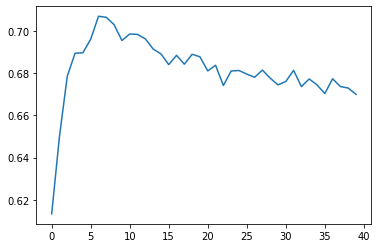

In [34]:
plt.plot(test_accuracy)

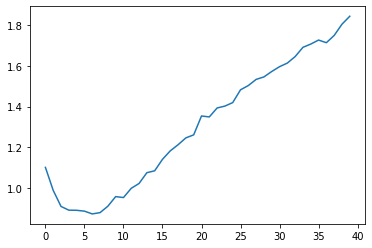

In [35]:
plt.plot(test_loss)